In [1]:
import requests, json
import pandas as pd
import numpy as np
import decimal
import time
from datetime import datetime, timedelta
from rich import print
import os
from dotenv import load_dotenv


# Load environment variables from .env file
load_dotenv()

api_key= os.getenv('taostats_api')

headers = {
            "accept": "application/json",
            "Authorization": api_key
        }

In [2]:
#get # of subnets

url = "https://api.taostats.io/api/subnet/latest/v1"
response = requests.get(url, headers=headers)
resJson = json.loads(response.text)
number_of_subnets = resJson['pagination']['total_items']

print(number_of_subnets)

77

In [3]:
counter =1 
alpha_min = 1000*1e9

alpha_holdings = {}

while counter <= number_of_subnets:
    page =1 
    total_pages = 2
    while page < total_pages:
        url = f"https://api.taostats.io/api/dtao/hotkey_alpha_shares/latest/v1?alpha_min={alpha_min}&netuid={counter}&limit=200"
        response = requests.get(url, headers=headers)
        resJson = json.loads(response.text)
        vali_data = resJson['data']
        for vali in vali_data:
            hk = vali['hotkey']['ss58']
            alpha = float(vali['alpha'])/1e9
            #no empty hotkeys
            if alpha >0:
                if hk not in alpha_holdings:
                    alpha_holdings[hk] = {}
            
                alpha_holdings[hk][counter] = alpha
        
        #loop incrementation
        total_pages = resJson['pagination']['total_pages']
        page +=1


    #next subnet
    
    counter +=1
#print(alpha_holdings)

In [4]:
alpha_holdings2 = {}
for index, holding in alpha_holdings.items():
    if len(holding) > 5:
        url  = f"https://api.taostats.io/api/validator/latest/v1?hotkey={index}"
        response = requests.get(url, headers=headers)
        resJson = json.loads(response.text)
        name = index
        if resJson['data'][0]['name'] != "None":
            name = resJson['data'][0]['name']
        alpha_holdings2[name] = holding
print(len(alpha_holdings2))


15

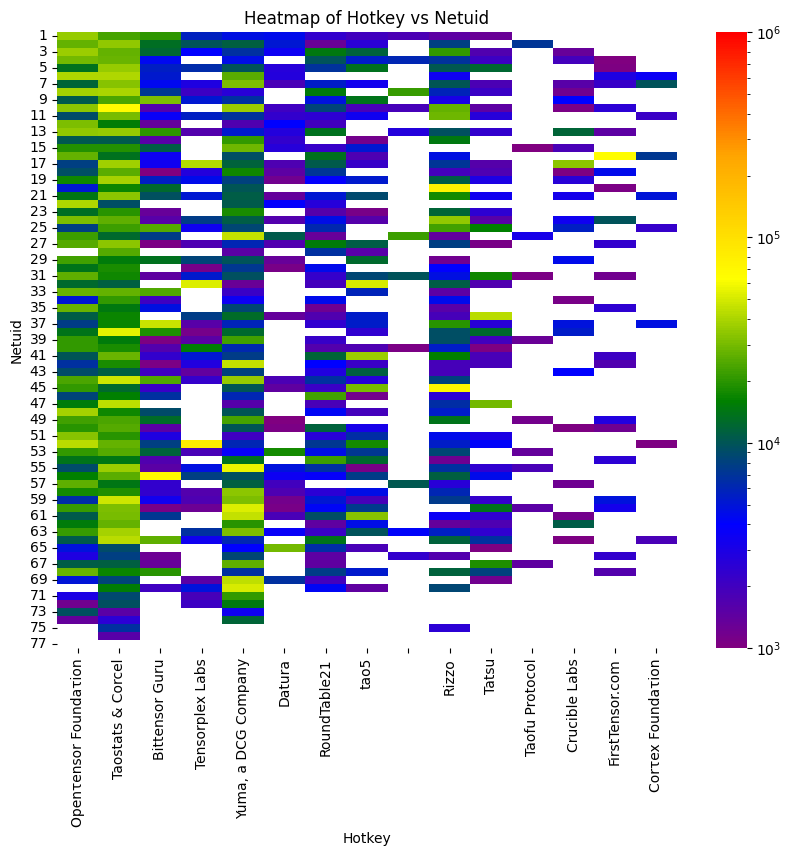

In [12]:
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns
# Define color map
cmap = mcolors.LinearSegmentedColormap.from_list("", ["purple","blue", "green", "yellow", "orange", "red"])
data = alpha_holdings2
# Create a DataFrame
df = pd.DataFrame(index=range(1, number_of_subnets+1), columns=data.keys(), dtype=float)
df = df.fillna(0)

# Populate DataFrame
for hotkey, netuids in data.items():
    for netuid, value in netuids.items():
        df.loc[netuid, hotkey] = value

# Create a mask for values over 1
mask = df < 1

# Create heatmap
plt.figure(figsize=(10, 8))
norm = mcolors.LogNorm(vmin=1000, vmax=1000000)
sns.heatmap(df, annot=False, cmap=cmap, mask=mask, norm=norm, vmin=1000, vmax=1000000, cbar_kws={'ticks': [ 1000, 10000, 100000,1000000],'format': '%.0f'})
cbar = plt.gcf().axes[-1]
cbar.set_yscale('log')
plt.title('Heatmap of Hotkey vs Netuid')
plt.xlabel('Hotkey')
plt.ylabel('Netuid')
# Save the plot as a JPEG file
plt.savefig('heatmap.jpg', bbox_inches='tight', dpi=300)


plt.show()

In [6]:
print(df.index)

RangeIndex(start=1, stop=78, step=1)

In [7]:
netuid_values = pd.to_numeric(df.index, errors='coerce')
print(netuid_values)

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77],
      dtype='int64')

In [8]:
num_hotkeys = len(df.columns)
print(num_hotkeys)

15

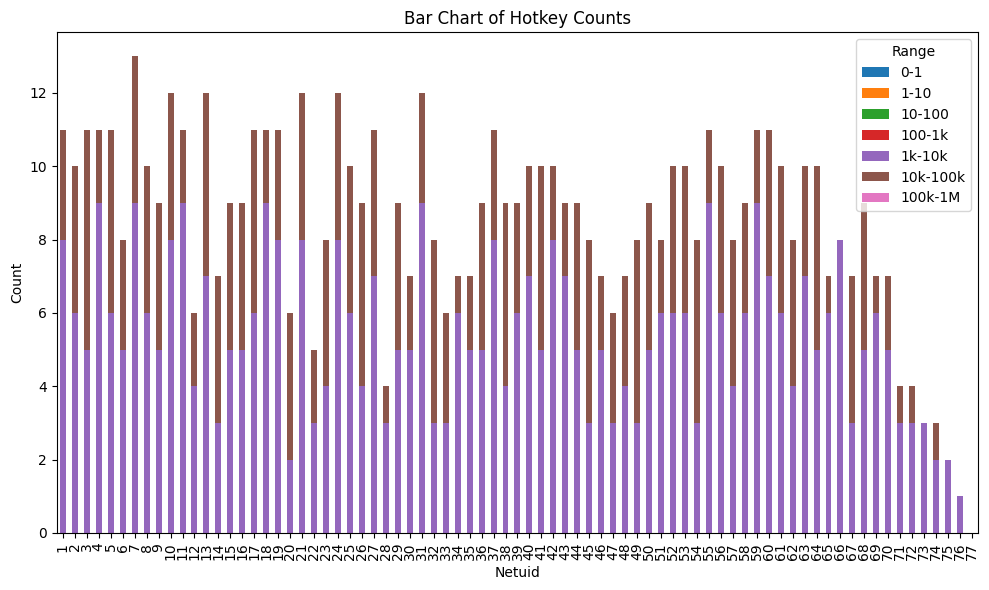

In [9]:
# Create a new DataFrame to store the counts
counts_df = pd.DataFrame(index=df.index, columns=['0-1', '1-10', '10-100', '100-1k', '1k-10k', '10k-100k', '100k-1M'])

# Count the number of hotkeys in each subnet that fall into the ranges
for netuid in df.index:
    values = df.loc[netuid, :]
    #counts_df.loc[netuid, '0-1'] = np.sum((values >= 0) & (values < 1))
    counts_df.loc[netuid, '1-10'] = np.sum((values >= 1) & (values < 10))
    counts_df.loc[netuid, '10-100'] = np.sum((values >= 10) & (values < 100))
    counts_df.loc[netuid, '100-1k'] = np.sum((values >= 100) & (values < 1000))
    counts_df.loc[netuid, '1k-10k'] = np.sum((values >= 1000) & (values < 10000))
    counts_df.loc[netuid, '10k-100k'] = np.sum((values >= 10000) & (values < 100000))
    counts_df.loc[netuid, '100k-1M'] = np.sum((values >= 100000) & (values < 1000000))

# Create a bar chart
counts_df.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Bar Chart of Hotkey Counts')
plt.xlabel('Netuid')
plt.ylabel('Count')
plt.legend(title='Range')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [10]:
alpha_holdings = {}
counter = 1
alpha_min =1000*1e9
url = f"https://api.taostats.io/api/dtao/hotkey_alpha_shares/latest/v1?alpha_min={alpha_min}&netuid={counter}&limit=200"
response = requests.get(url, headers=headers)
resJson = json.loads(response.text)
vali_data = resJson['data']
for vali in vali_data:
    hk = vali['hotkey']['ss58']
    alpha = float(vali['alpha'])/1e9
    #no empty hotkeys
    if alpha >0:
        if hk not in alpha_holdings:
            alpha_holdings[hk] = {}
    
        alpha_holdings[hk][counter] = alpha